#**유통 판매량 예측 및 재고 최적화**
## **단계2 : 모델링을 위한 데이터 전처리**

# **0.미션**

* 단계1 상품별 데이터셋 만들기
    * 가설로 도출된 변수를 반영한 데이터셋을 상품별로 생성
* 단계2 기초 모델 생성
    * base line model : dense layer만 이용해서 기초 모델 생성
    * LSTM, CNN 알고리즘을 이용해서 기초 모델 생성

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/project/'

### **(2) 라이브러리 설치 및 불러오기**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

#### 1) 데이터로딩

In [ ]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

In [ ]:
sales['Date'].min(), sales['Date'].max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2017-02-28 00:00:00'))

#### 2) 기본 정보 조회

In [ ]:
oil_price.head()

,Date,WTI_Price
0,2014-01-01,NaN
1,2014-01-02,95.14
2,2014-01-03,93.66
3,2014-01-06,93.12
4,2014-01-07,93.31


In [ ]:
products.head()

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
0,20,HG001,Gardening Tools,Household Goods,2,50
1,27,HH001,Home Appliances,Household Goods,2,150
2,16,HK001,Kitchen,Household Goods,2,23
3,15,HK002,Kitchen,Household Goods,2,41
4,32,GS001,Seafood,Grocery,3,34


In [ ]:
sales.head()

,Date,Store_ID,Qty,Product_ID
0,2014-01-01,1,0.0,3
1,2014-01-01,1,0.0,5
2,2014-01-01,1,0.0,7
3,2014-01-01,1,0.0,8
4,2014-01-01,1,0.0,10


In [ ]:
orders.head()

,Date,Store_ID,CustomerCount
0,2014-01-01,25,840
1,2014-01-01,36,487
2,2014-01-02,1,1875
3,2014-01-02,2,2122
4,2014-01-02,3,3350


In [ ]:
stores.head()

,Store_ID,City,State,Store_Type
0,1,Saint Paul,\tMinnesota,4
1,2,Saint Paul,\tMinnesota,4
2,3,Saint Paul,\tMinnesota,4
3,4,Saint Paul,\tMinnesota,4
4,5,Oklahoma City,Oklahoma,4


# **2.데이터셋 구성하기**

* 세부 요구사항
    * 상품코드 별로 각각 데이터셋을 구성해야 합니다.
    * 도출된 변수들을 포함하는 데이터셋을 구성합니다.


In [ ]:
def make_dataset(Product_ID):

    # 1. 기본 데이터 준비
    leadTime = products.loc[products['Product_ID']==Product_ID, 'LeadTime'].values[0]
    temp1 = sales.loc[(sales['Store_ID']==44) & (sales['Product_ID']==Product_ID), ['Date','Qty']]
    temp2 = orders.loc[orders['Store_ID']==44, ['Date','CustomerCount']]
    temp3 = pd.merge(temp1, temp2)
    temp3['target'] = temp3['Qty'].shift(-leadTime)
    temp3.dropna(inplace = True)

    # 2. feature engineering
    # 2.1 날짜 요소 추출
    temp3['WeekDay'] = temp3['Date'].dt.day_name()
    temp3['Month'] = temp3['Date'].dt.month

    # 2.2 동일 카테고리 판매량 합계
    Category = products.loc[products['Product_ID'].isin([Product_ID]), 'Category'].to_list()
    Product_IDs = products.loc[products['Category'].isin(Category), 'Product_ID'].to_list()
    temp4 = sales.loc[(sales['Store_ID']==44) & (sales['Product_ID'].isin(Product_IDs))].groupby('Date', as_index = False)['Qty'].sum()
    temp4.columns = ['Date', 'Category_Qty']
    temp3 = pd.merge(temp3, temp4, how = 'left')

    # 2.3 동일 지역 방문객 수
    City = stores.loc[stores['Store_ID']==44, 'City'].values[0]
    Store_IDs = stores.loc[stores['City']==City, 'Store_ID'].to_list()
    temp5 = orders.loc[orders['Store_ID'].isin(Store_IDs)].groupby('Date', as_index = False)['CustomerCount'].sum()
    temp5.columns = ['Date', 'City_CustCount']
    temp3 = pd.merge(temp3, temp5, how = 'left')

    # 2.4 oil price MA14
    temp3 = pd.merge(temp3, oil_price, how = 'left')
    temp3['WTI_Price'] = temp3['WTI_Price'].rolling(14, min_periods=1).mean()

    return temp3


## **(1) 상품 : 3 - Beverage**

In [ ]:
data03 = make_dataset(3)
data03.head()

,Date,Qty,CustomerCount,target,WeekDay,Month,Category_Qty,City_CustCount,WTI_Price
0,2014-01-02,9853.0,4422,15153.0,Thursday,1,10142.0,45969,95.140000
1,2014-01-03,8647.0,4167,15606.0,Friday,1,8980.0,42386,94.400000
2,2014-01-04,15153.0,5341,7900.0,Saturday,1,15684.0,52293,94.400000
3,2014-01-05,15606.0,5123,7188.0,Sunday,1,15606.0,49199,94.400000
4,2014-01-06,7900.0,3917,8800.0,Monday,1,8083.0,39105,93.973333


## **(2) 상품 : 12 - Milk**

In [ ]:
data12 = make_dataset(12)
data12.head()

,Date,Qty,CustomerCount,target,WeekDay,Month,Category_Qty,City_CustCount,WTI_Price
0,2014-01-02,9647.0,4422,14490.0,Thursday,1,15195.550,45969,95.140000
1,2014-01-03,8879.0,4167,7614.0,Friday,1,13952.689,42386,94.400000
2,2014-01-04,14188.0,5341,7124.0,Saturday,1,22059.125,52293,94.400000
3,2014-01-05,14490.0,5123,8683.0,Sunday,1,22443.851,49199,94.400000
4,2014-01-06,7614.0,3917,6731.0,Monday,1,11853.281,39105,93.973333


## **(3) 상품 : 42 - Agricultural products**

In [ ]:
data42 = make_dataset(42)
data42.head()

,Date,Qty,CustomerCount,target,WeekDay,Month,Category_Qty,City_CustCount,WTI_Price
0,2014-01-02,76.0,4422,88.0,Thursday,1,1962.62200,45969,95.140000
1,2014-01-03,74.0,4167,65.0,Friday,1,2144.99700,42386,94.400000
2,2014-01-04,78.0,5341,78.0,Saturday,1,2773.83000,52293,94.400000
3,2014-01-05,88.0,5123,73.0,Sunday,1,2542.78700,49199,94.400000
4,2014-01-06,65.0,3917,78.0,Monday,1,1284.36197,39105,93.973333


# **3.Baseline Model**

* **세부 요구사항**
    * 데이터 준비
        * 스케일링
            * 교과서 적으로는 데이터 분할 이후 스케일링하는게 맞지만, 데이터 건수가 충분히 크다면, 스케일링을 먼저 하기도 합니다.
            * 여기서는 먼저 스케일링을 한 후 데이터 분할을 합니다.
        * 데이터 분할
            * 검증셋 구성 : 학습용 데이터에서 최근 60일을 검증셋으로 사용.

    * 모델링
        * Dense Layer 1개(output layer)만으로 모델을 생성합니다.
        * 모델의 검증 성능을 평가하고 기록합니다.
        * 평가 지표 : RMSE, MAE, MAPE, R2 Score


In [ ]:
def preproc(data, y_scale = False) :
    target = 'target'
    x = data.drop(['Date', target], axis = 1)
    y = data.loc[:, target]

    # 가변수화
    x['WeekDay'] = pd.Categorical(x['WeekDay'], categories = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday' ])
    x['Month'] = pd.Categorical(x['Month'], categories = [1,2,3,4,5,6,7,8,9,10,11,12])
    x = pd.get_dummies(x, columns = ['WeekDay','Month'])

    # 스케일링
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)

    # y scale
    if y_scale == True :
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else :
        y_min, y_max = np.nan, np.nan

    # 분할
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 60, shuffle = False)

    return x_train, x_val, y_train, y_val, scaler, y_min, y_max

## **(1) 상품 : 3 - Beverage**

### **1) 데이터 준비**

In [ ]:
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc(data03, True)
y_min, y_max

(2853.0, 25413.0)

### **2) 모델링**

In [ ]:
clear_session()

nfeat = x_train.shape[1]

model03_00 = Sequential([Dense(1, input_shape = (nfeat, ) )])
model03_00.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 25 (100.00 Byte)
Trainable params: 25 (100.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


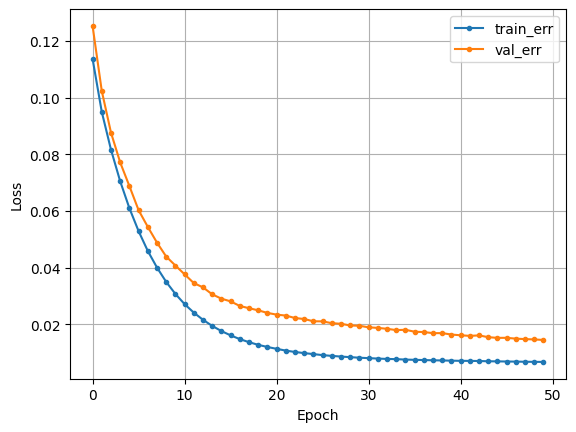

In [ ]:
model03_00.compile(optimizer = 'adam', loss = 'mse')
hist = model03_00.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model03_00.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

5/5 [==============================] - 0s 2ms/step
MAE :  2169.8263444010418
MAPE :  0.18251074427299874
R2 :  0.3717285705361033


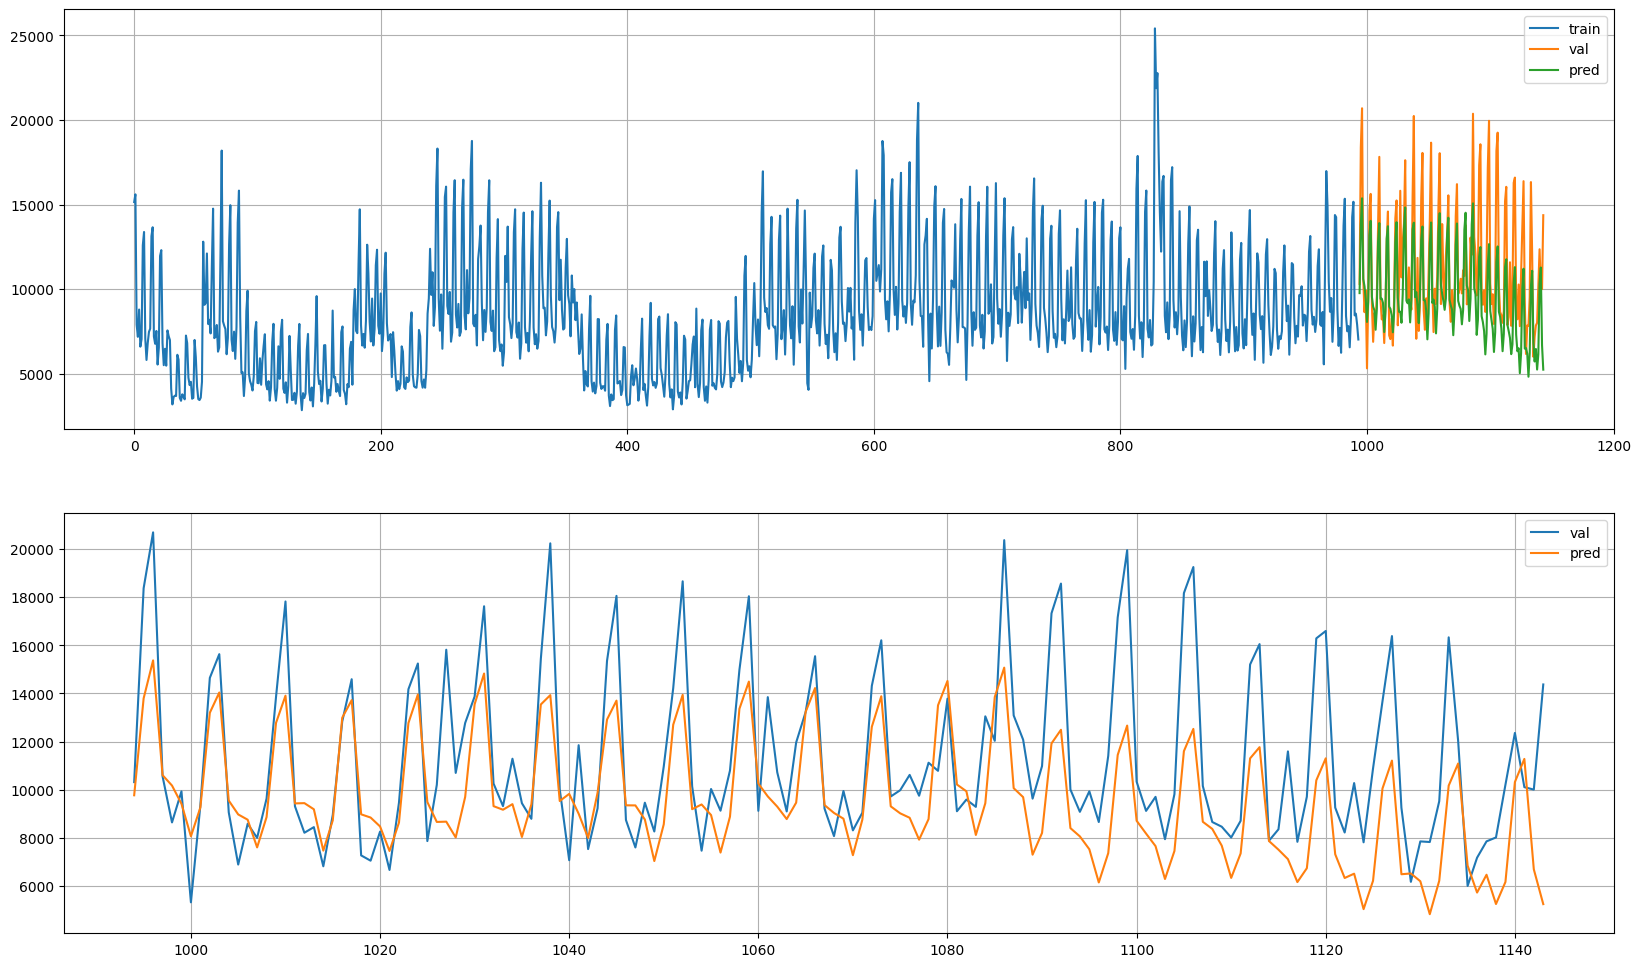

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

## **(2) 상품 : 12 - Milk**

### **1) 데이터 준비**

In [ ]:
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc(data12, True)
y_mi, y_ma

(4390.0, 37106.0)

### **2) 모델링**

In [ ]:
clear_session()

nfeat = x_train.shape[1]

model12_00 = Sequential([Dense(1, input_shape = (nfeat, ) )])
model12_00.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 25 (100.00 Byte)
Trainable params: 25 (100.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


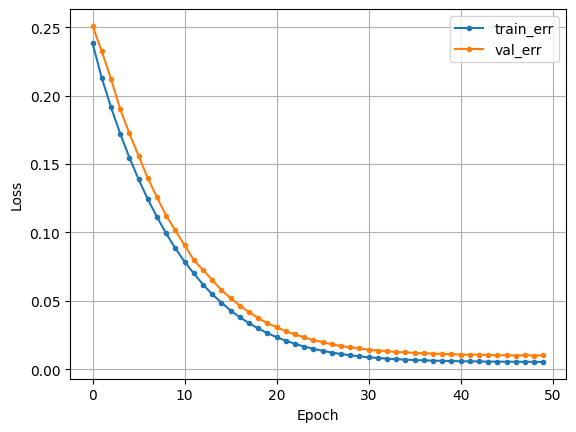

In [ ]:
model12_00.compile(optimizer = 'adam', loss = 'mse')
hist = model12_00.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model12_00.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

5/5 [==============================] - 0s 2ms/step
MAE :  2640.3872233072916
MAPE :  0.19948615846134946
R2 :  0.1635113950217375


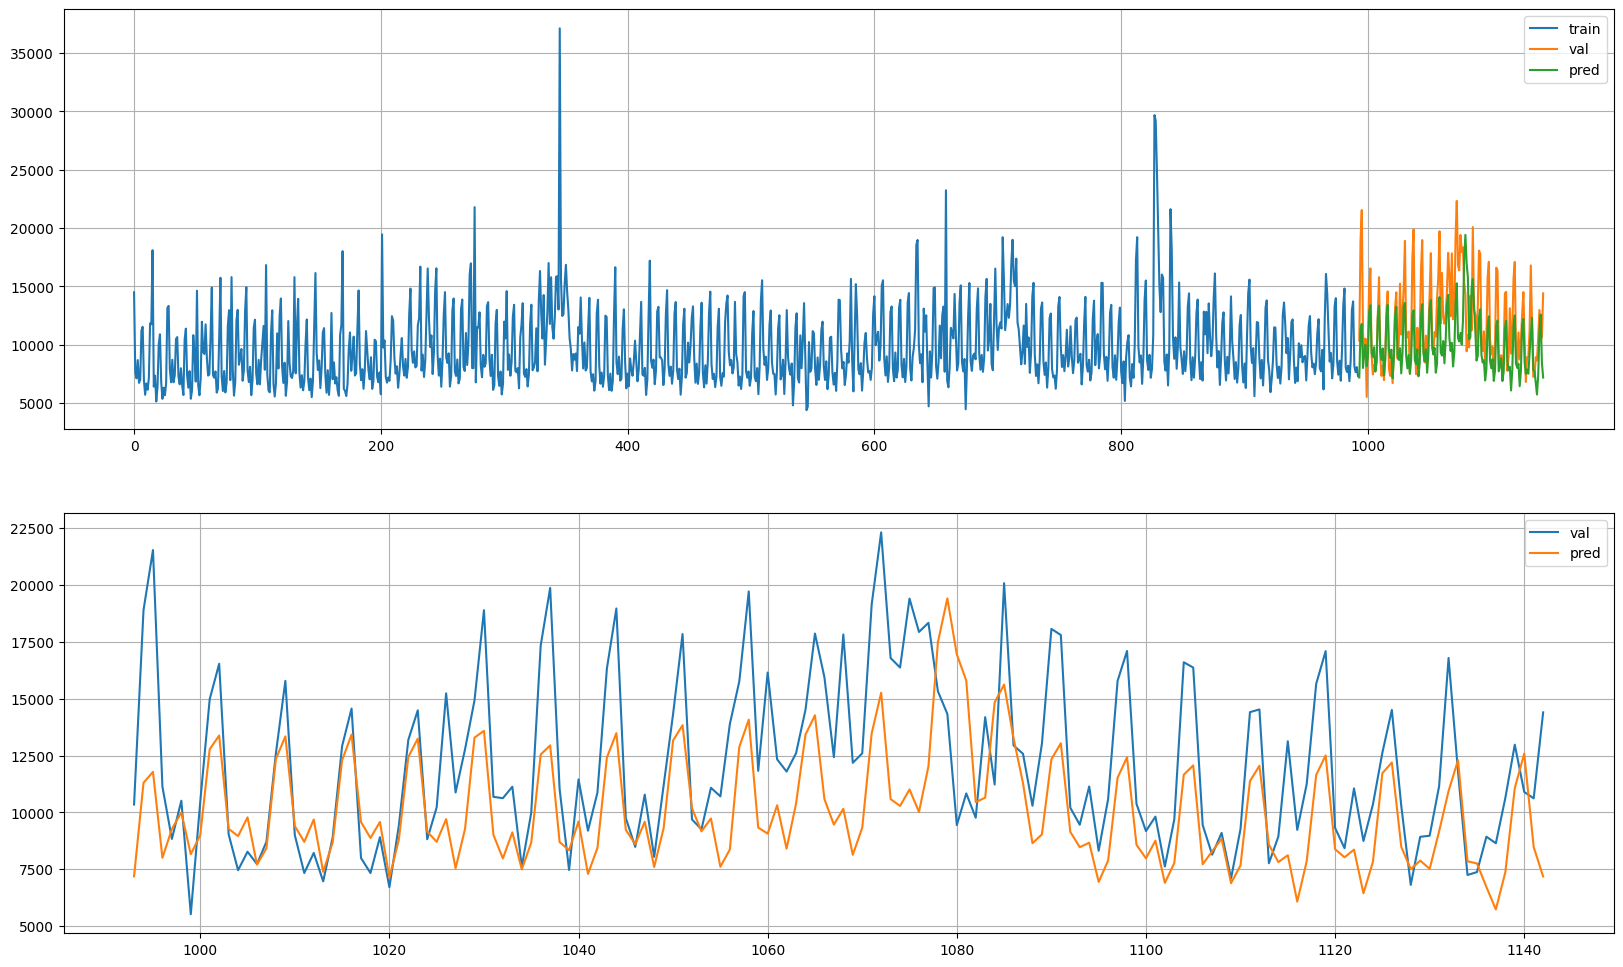

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

## **(3) 상품 : 42 - Agricultural products**

### **1) 데이터 준비**

In [ ]:
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc(data42, True)
y_mi, y_ma

(45.0, 196.0)

### **2) 모델링**

In [ ]:
clear_session()

nfeat = x_train.shape[1]

model42_00 = Sequential([Dense(1, input_shape = (nfeat, ) )])
model42_00.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 25 (100.00 Byte)
Trainable params: 25 (100.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


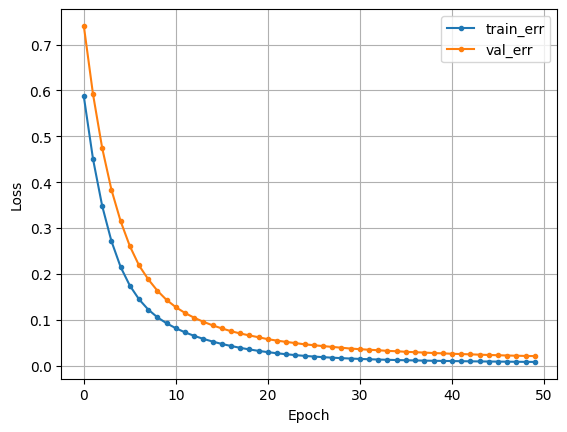

In [ ]:
model42_00.compile(optimizer = 'adam', loss = 'mse')
hist = model42_00.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model42_00.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

5/5 [==============================] - 0s 2ms/step
MAE :  12.865870691935221
MAPE :  0.12442226402629397
R2 :  0.5172352473826538


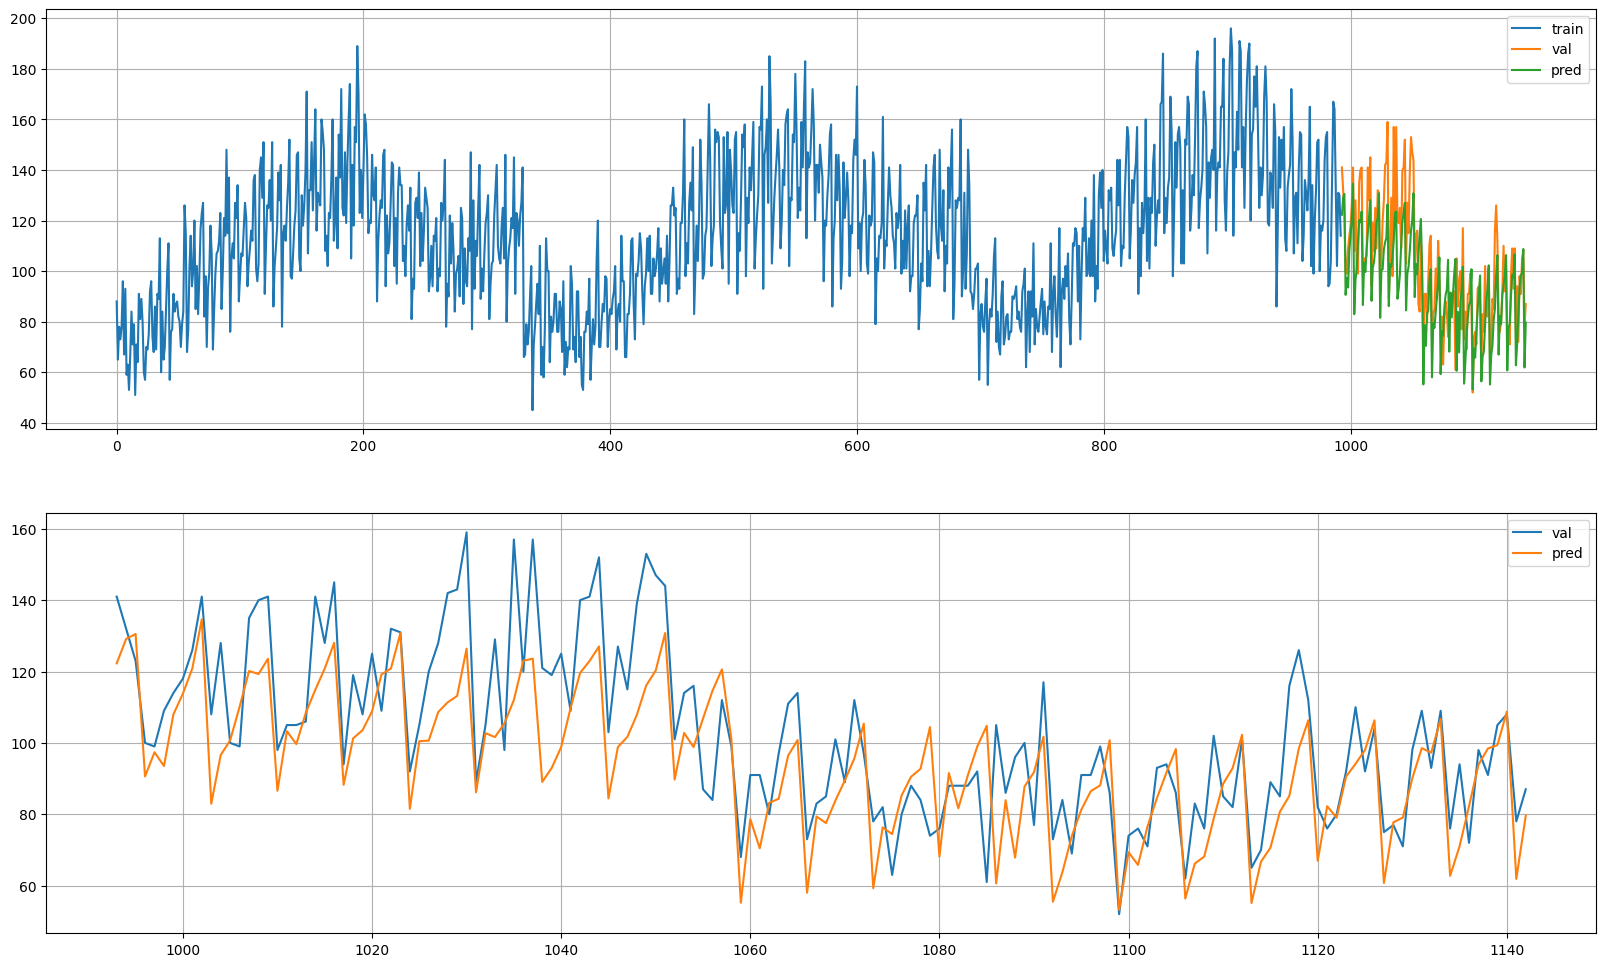

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

# **4.LSTM, CNN 초기 모델**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.

In [ ]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

In [ ]:
def preproc3d(data, timesteps, y_scale = False) :
    target = 'target'
    x = data.drop(['Date', target], axis = 1)
    y = data.loc[:, target]

    # 가변수화
    x['WeekDay'] = pd.Categorical(x['WeekDay'], categories = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday' ])
    x['Month'] = pd.Categorical(x['Month'], categories = [1,2,3,4,5,6,7,8,9,10,11,12])
    x = pd.get_dummies(x, columns = ['WeekDay','Month'])
    col_names = list(x)


    # 스케일링
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x, columns=col_names)

    # y scale
    if y_scale == True :
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else :
        y_min, y_max = np.nan, np.nan

    # 3차원 변환
    x3, y3 = temporalize(x, y, timesteps)

    # 분할
    x_train, x_val, y_train, y_val = train_test_split(x3, y3, test_size = 120, shuffle = False)

    return x_train, x_val, y_train, y_val, scaler, y_min, y_max

## **(1) LSTM 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [ ]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(data03, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(2853.0, 25413.0, (1018, 7, 24), (120, 7, 24))

* **모델링**

In [ ]:
clear_session()

_, ts, nfeat = x_train.shape

model03_01 = Sequential([LSTM(4, input_shape = (ts, nfeat) ),
                         Dense(1)])
model03_01.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 464       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 469 (1.83 KB)
Trainable params: 469 (1.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


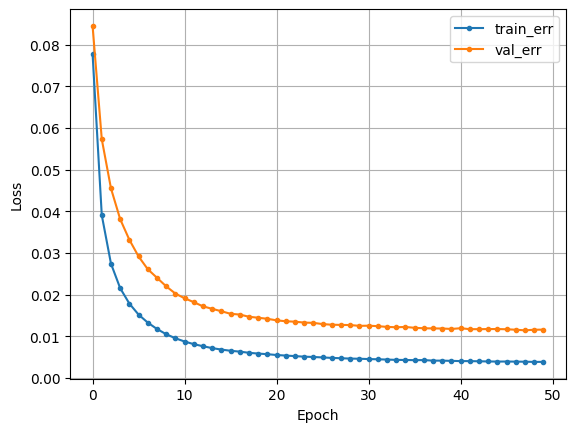

In [ ]:
model03_01.compile(optimizer = 'adam', loss = 'mse')
hist = model03_01.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model03_01.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 [==============================] - 1s 5ms/step
MAE :  1593.0225708007813
MAPE :  0.1351406826518751
R2 :  0.6200608639297767


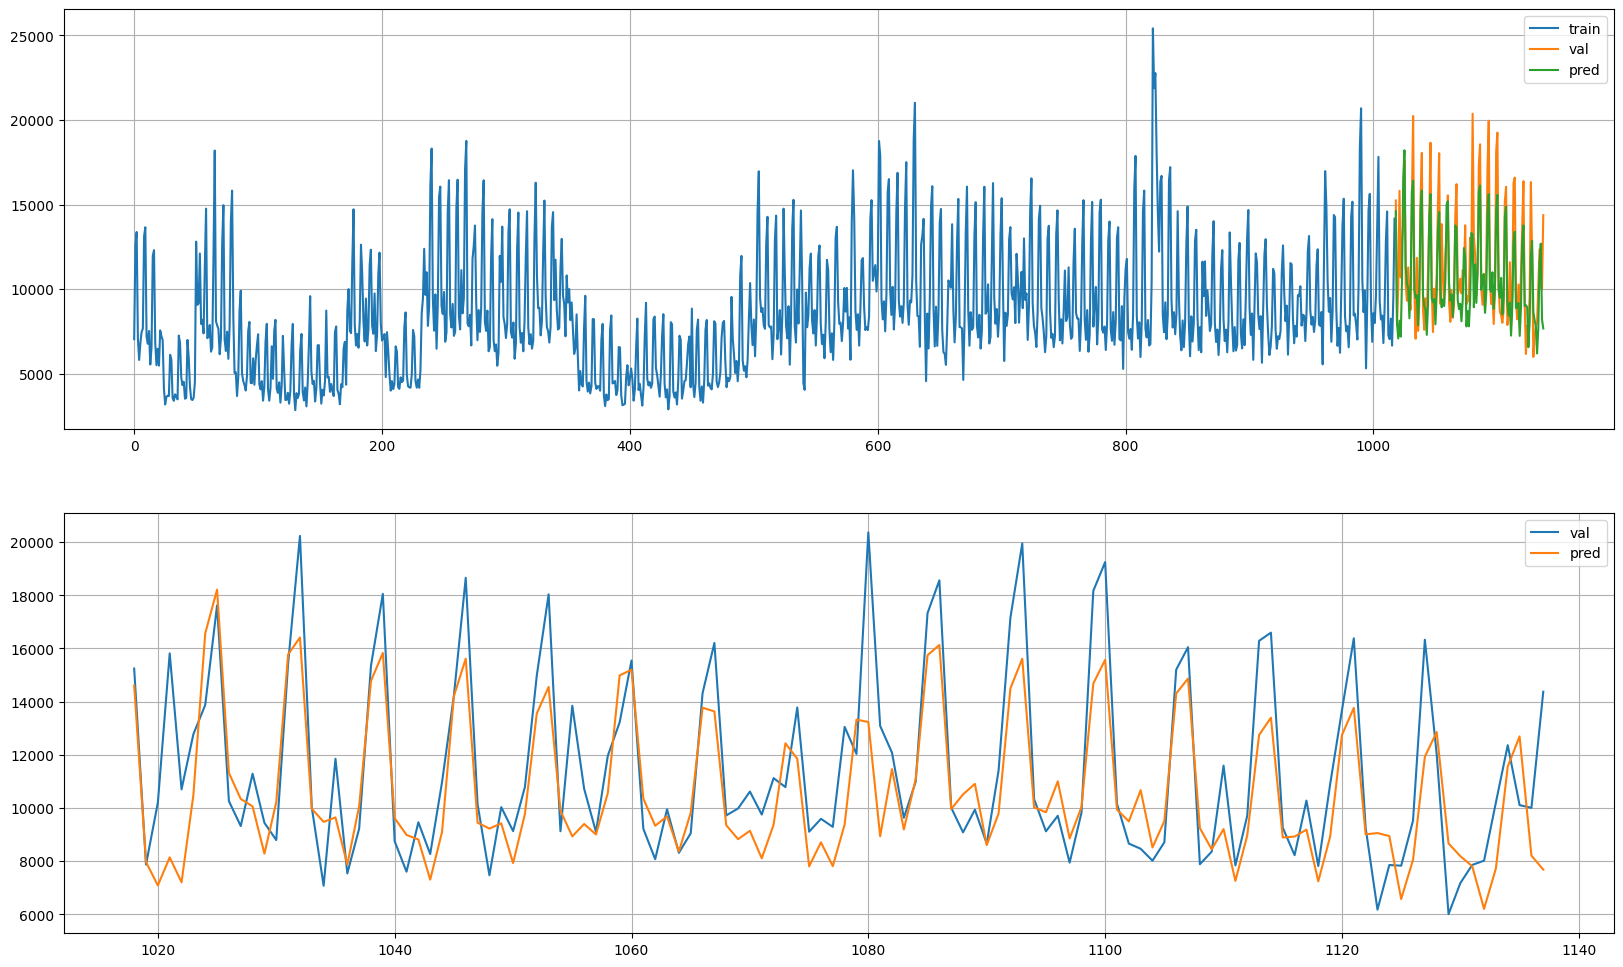

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [ ]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(data12, timesteps, True)
y_min, y_max x_train.shape, x_val.shape

(4390.0, 37106.0, (1017, 7, 24), (120, 7, 24))

* **모델링**

In [ ]:
clear_session()

_, ts, nfeat = x_train.shape

model12_01 = Sequential([LSTM(4, input_shape = (ts, nfeat) ),
                         Dense(1)])
model12_01.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 464       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 469 (1.83 KB)
Trainable params: 469 (1.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


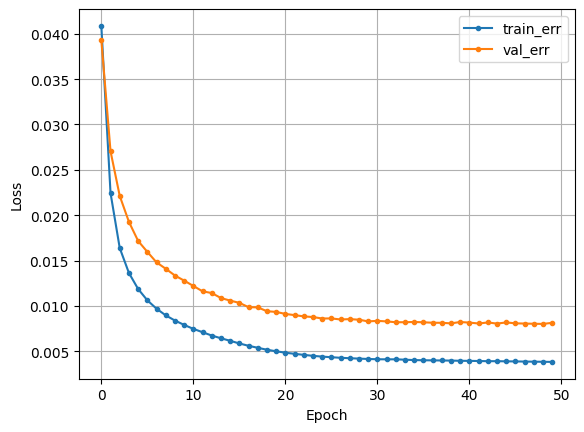

In [ ]:
model12_01.compile(optimizer = 'adam', loss = 'mse')
hist = model12_01.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model12_01.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 [==============================] - 0s 3ms/step
MAE :  2305.8858968098957
MAPE :  0.17270110059969193
R2 :  0.34987805878761935


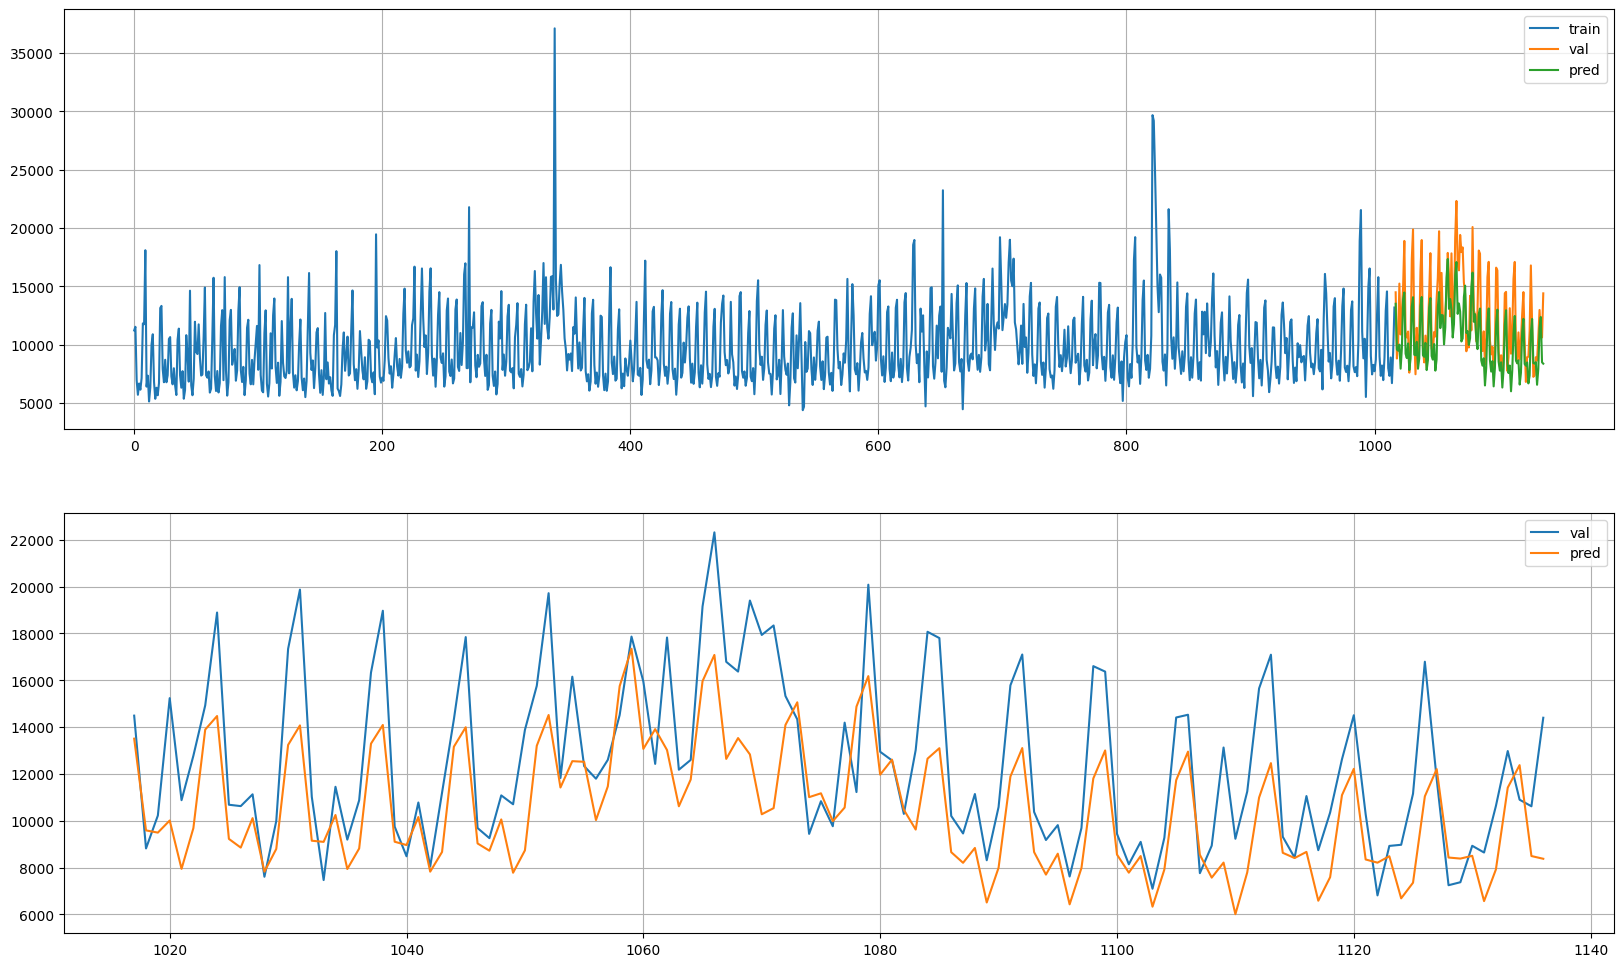

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [ ]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(data42, timesteps, True)
y_min, y_max x_train.shape, x_val.shape

(45.0, 196.0, (1017, 7, 24), (120, 7, 24))

* **모델링**

In [ ]:
clear_session()

_, ts, nfeat = x_train.shape

model42_01 = Sequential([LSTM(4, input_shape = (ts, nfeat) ),
                         Dense(1)])
model42_01.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 464       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 469 (1.83 KB)
Trainable params: 469 (1.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


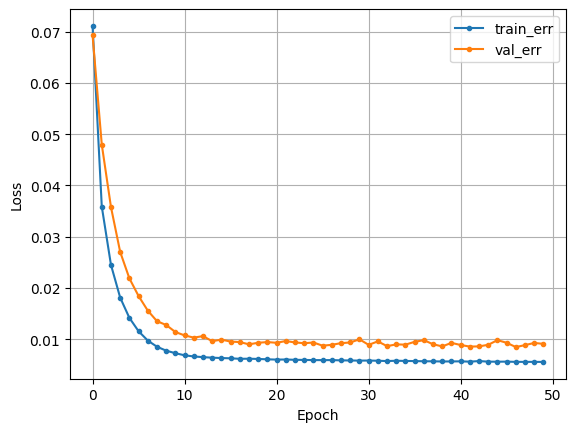

In [ ]:
model42_01.compile(optimizer = 'adam', loss = 'mse')
hist = model42_01.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model42_01.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 [==============================] - 0s 3ms/step
MAE :  12.06759926478068
MAPE :  0.12290253897334844
R2 :  0.5740864473059901


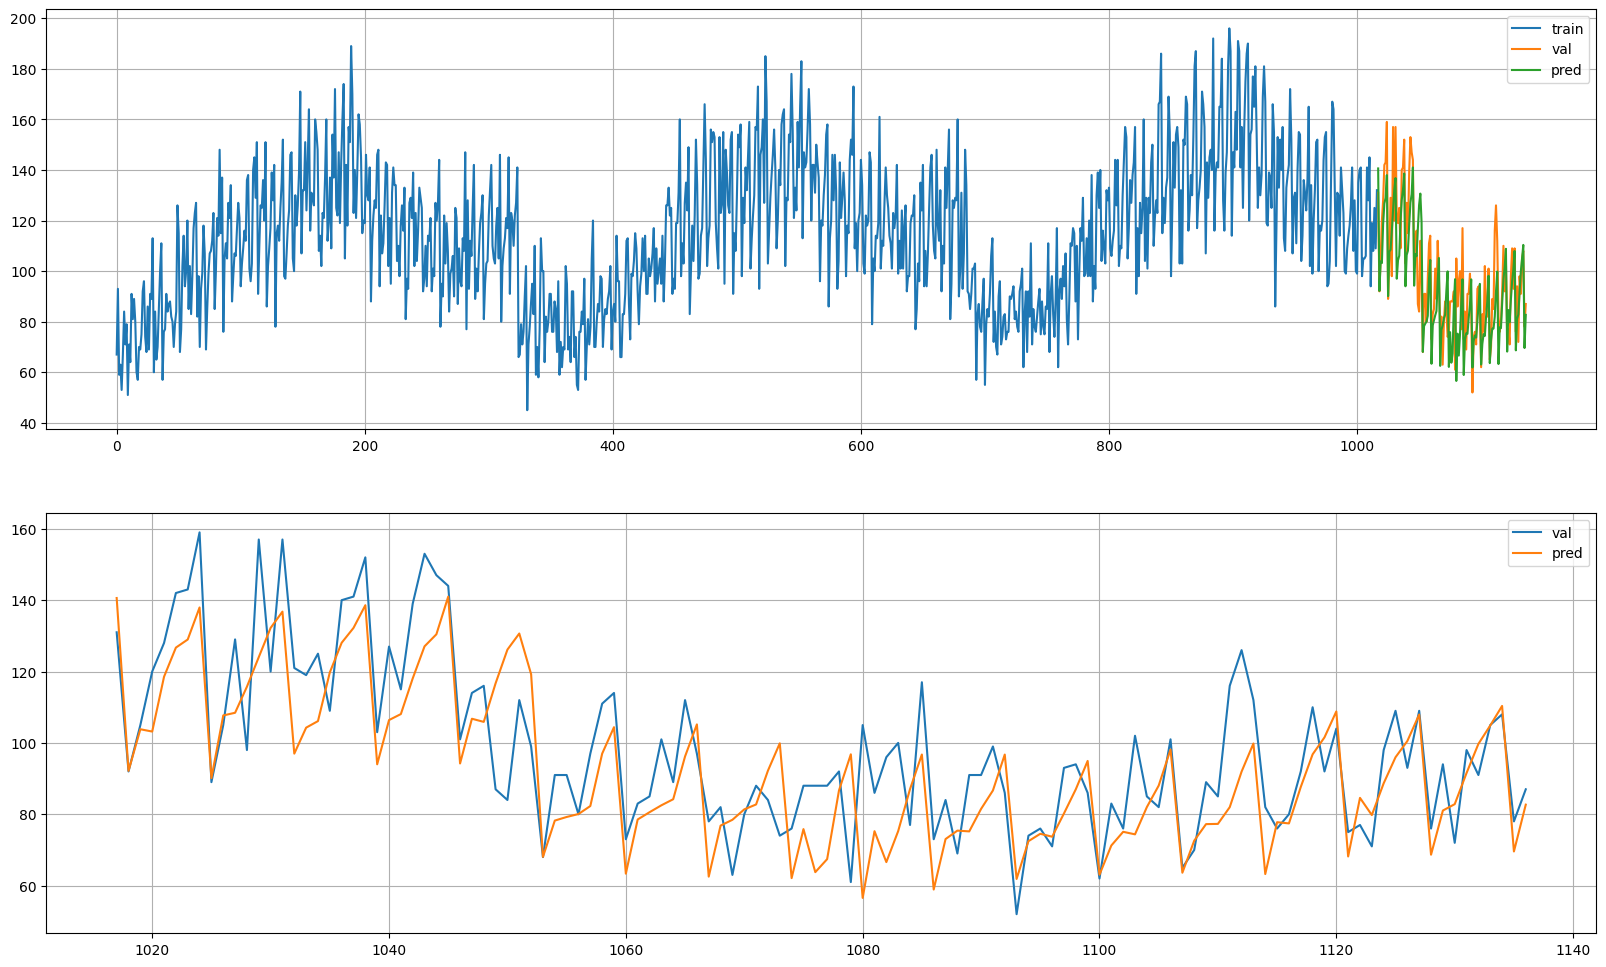

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

## **(2) CNN 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [ ]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(data03, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(2853.0, 25413.0, (1018, 7, 24), (120, 7, 24))

* **모델링**

In [ ]:
clear_session()

_, ts, nfeat = x_train.shape

model03_01 = Sequential([Conv1D(4, 3, input_shape = (ts, nfeat), activation='relu', padding = 'same'),
                         Flatten(),
                         Dense(1)])
model03_01.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 4)              292       
                                                                 
 flatten (Flatten)           (None, 28)                0         
                                                                 
 dense (Dense)               (None, 1)                 29        
                                                                 
Total params: 321 (1.25 KB)
Trainable params: 321 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


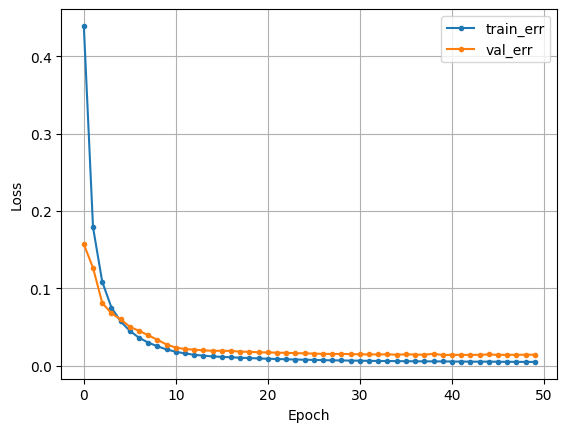

In [ ]:
model03_01.compile(optimizer = 'adam', loss = 'mse')
hist = model03_01.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model03_01.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 [==============================] - 0s 3ms/step
MAE :  2000.5462890625
MAPE :  0.1754632962312145
R2 :  0.3980852643782694


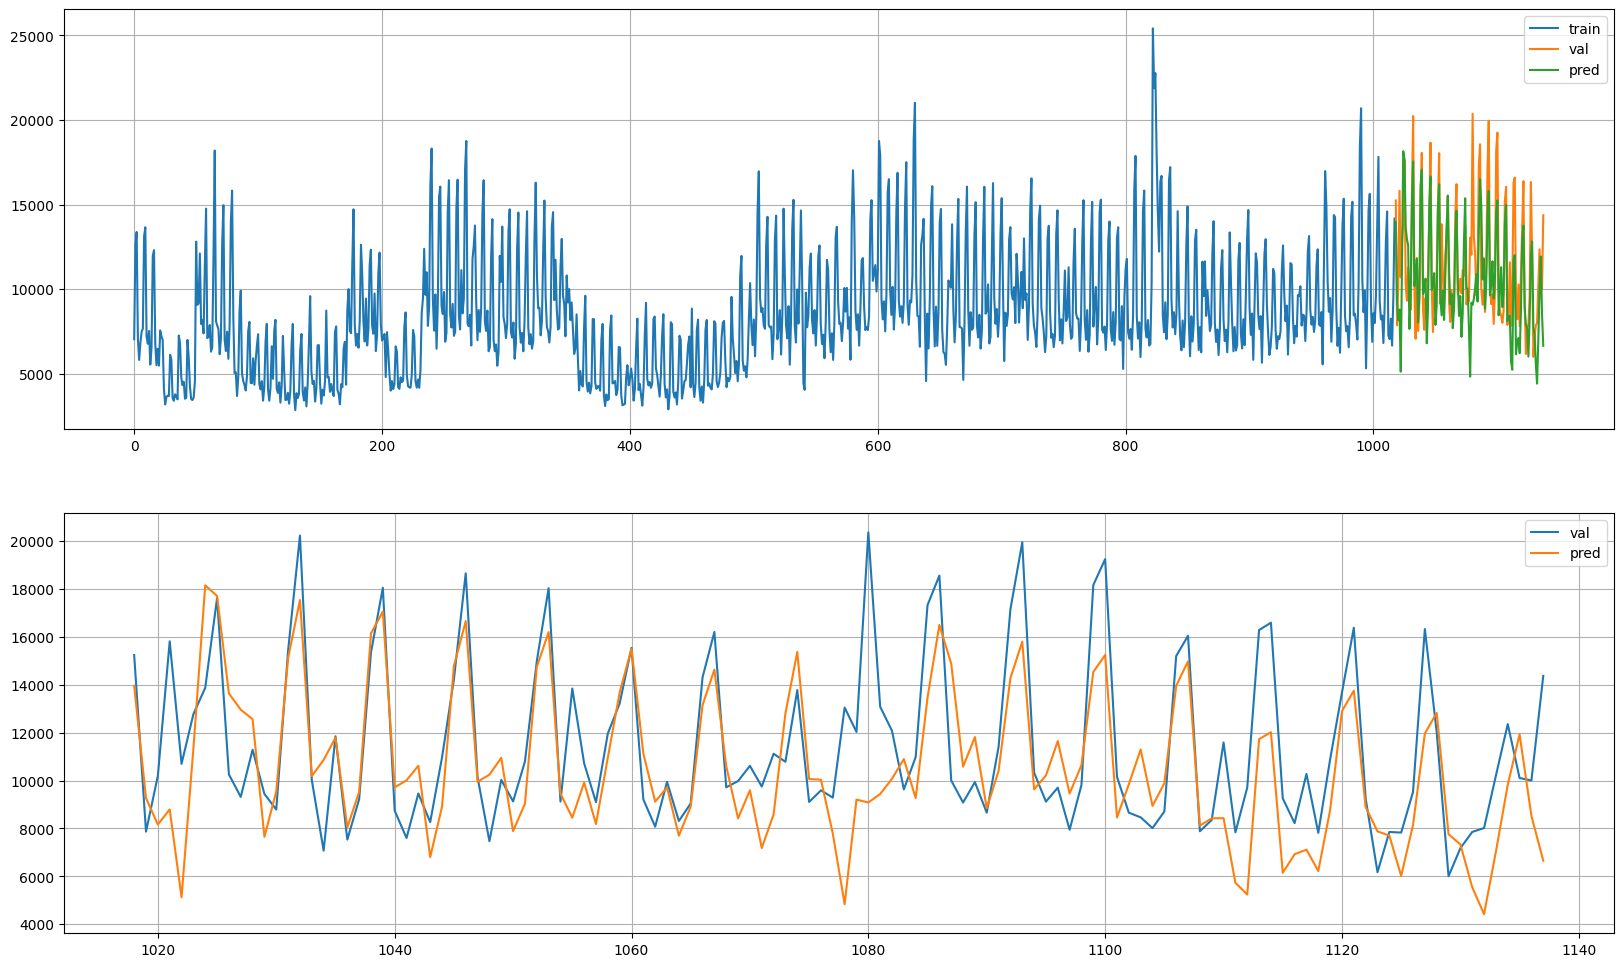

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [ ]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(data12, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(4390.0, 37106.0, (1017, 7, 24), (120, 7, 24))

* **모델링**

In [ ]:
clear_session()

_, ts, nfeat = x_train.shape

model12_01 = Sequential([Conv1D(4, 3, input_shape = (ts, nfeat), activation='relu', padding = 'same'),
                         Flatten(),
                         Dense(1)])
model12_01.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 4)              292       
                                                                 
 flatten (Flatten)           (None, 28)                0         
                                                                 
 dense (Dense)               (None, 1)                 29        
                                                                 
Total params: 321 (1.25 KB)
Trainable params: 321 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


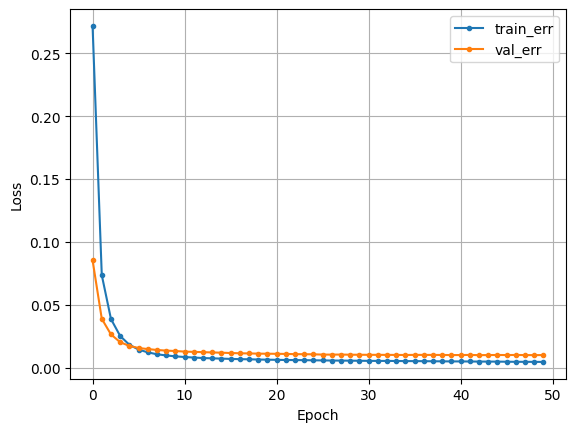

In [ ]:
model12_01.compile(optimizer = 'adam', loss = 'mse')
hist = model12_01.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model12_01.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 [==============================] - 0s 4ms/step
MAE :  2543.171183268229
MAPE :  0.18617686415026272
R2 :  0.1066140319798653


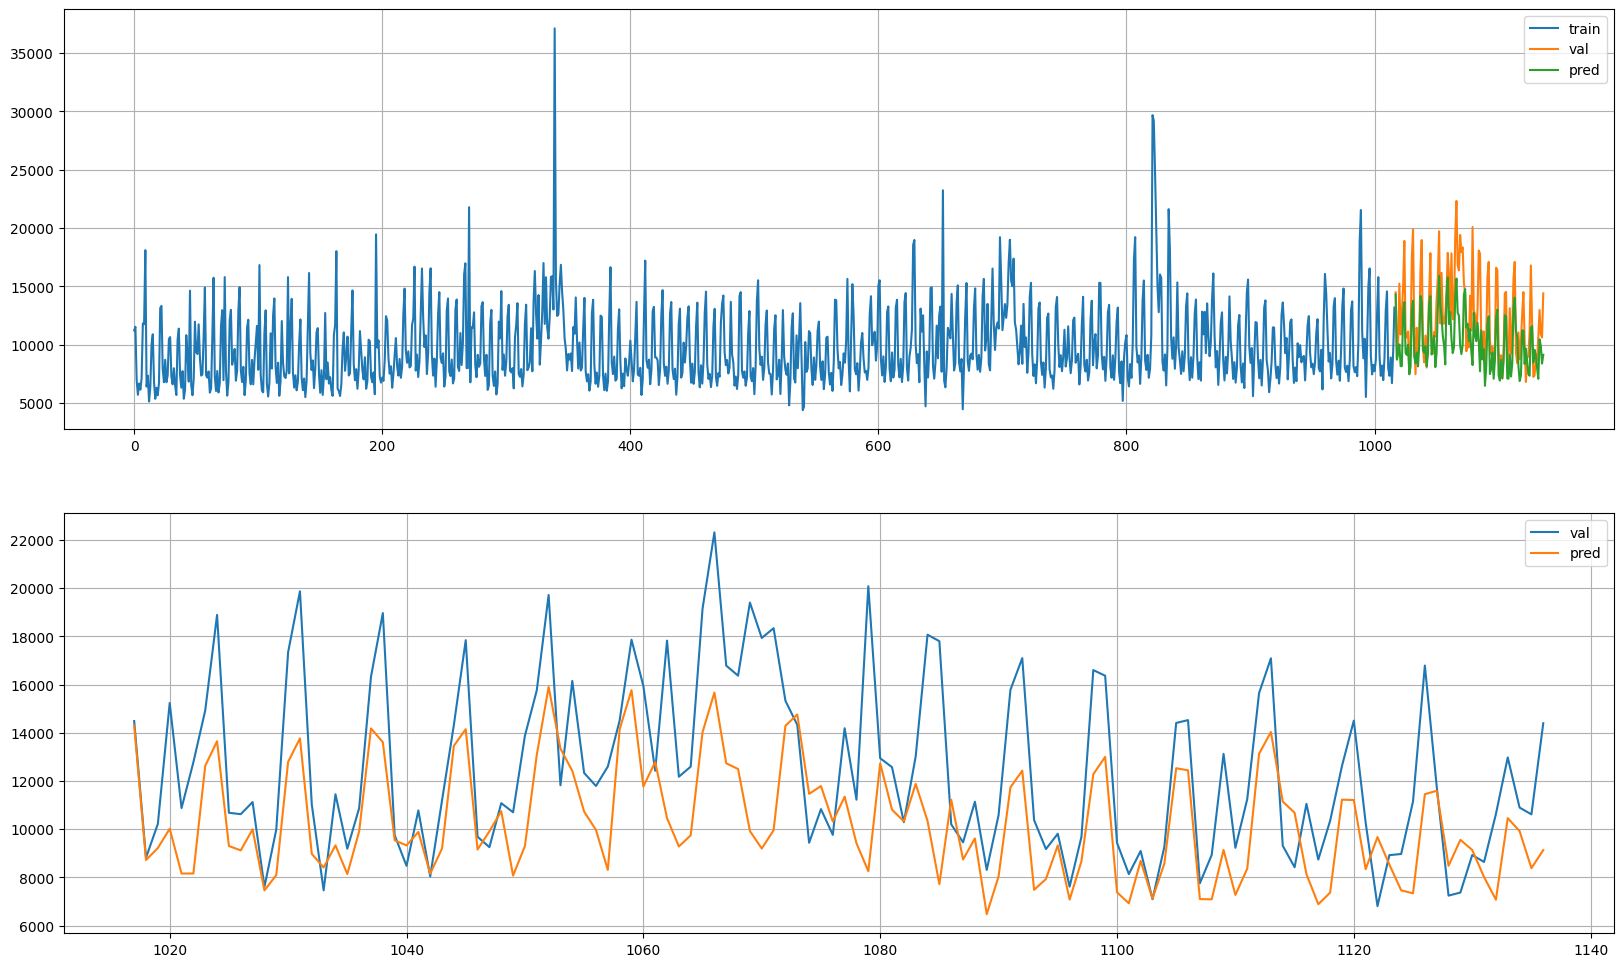

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [ ]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(data42, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(45.0, 196.0, (1017, 7, 24), (120, 7, 24))

* **모델링**

In [ ]:
clear_session()

_, ts, nfeat = x_train.shape

model42_01 = Sequential([Conv1D(4, 3, input_shape = (ts, nfeat), activation='relu', padding = 'same'),
                         Flatten(),
                         Dense(1)])
model42_01.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 4)              292       
                                                                 
 flatten (Flatten)           (None, 28)                0         
                                                                 
 dense (Dense)               (None, 1)                 29        
                                                                 
Total params: 321 (1.25 KB)
Trainable params: 321 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


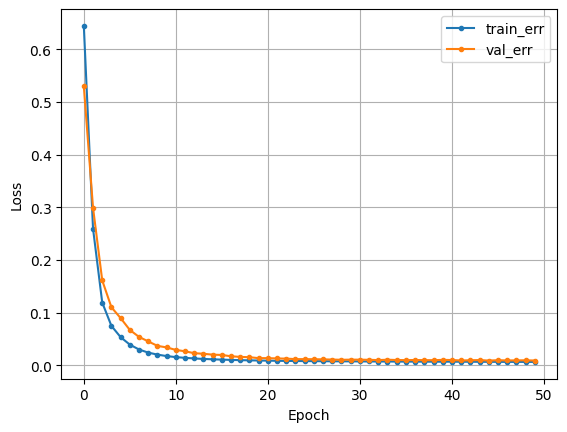

In [ ]:
model42_01.compile(optimizer = 'adam', loss = 'mse')
hist = model42_01.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model42_01.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 [==============================] - 0s 2ms/step
MAE :  11.647602526346843
MAPE :  0.11950933009962891
R2 :  0.5834071311007913


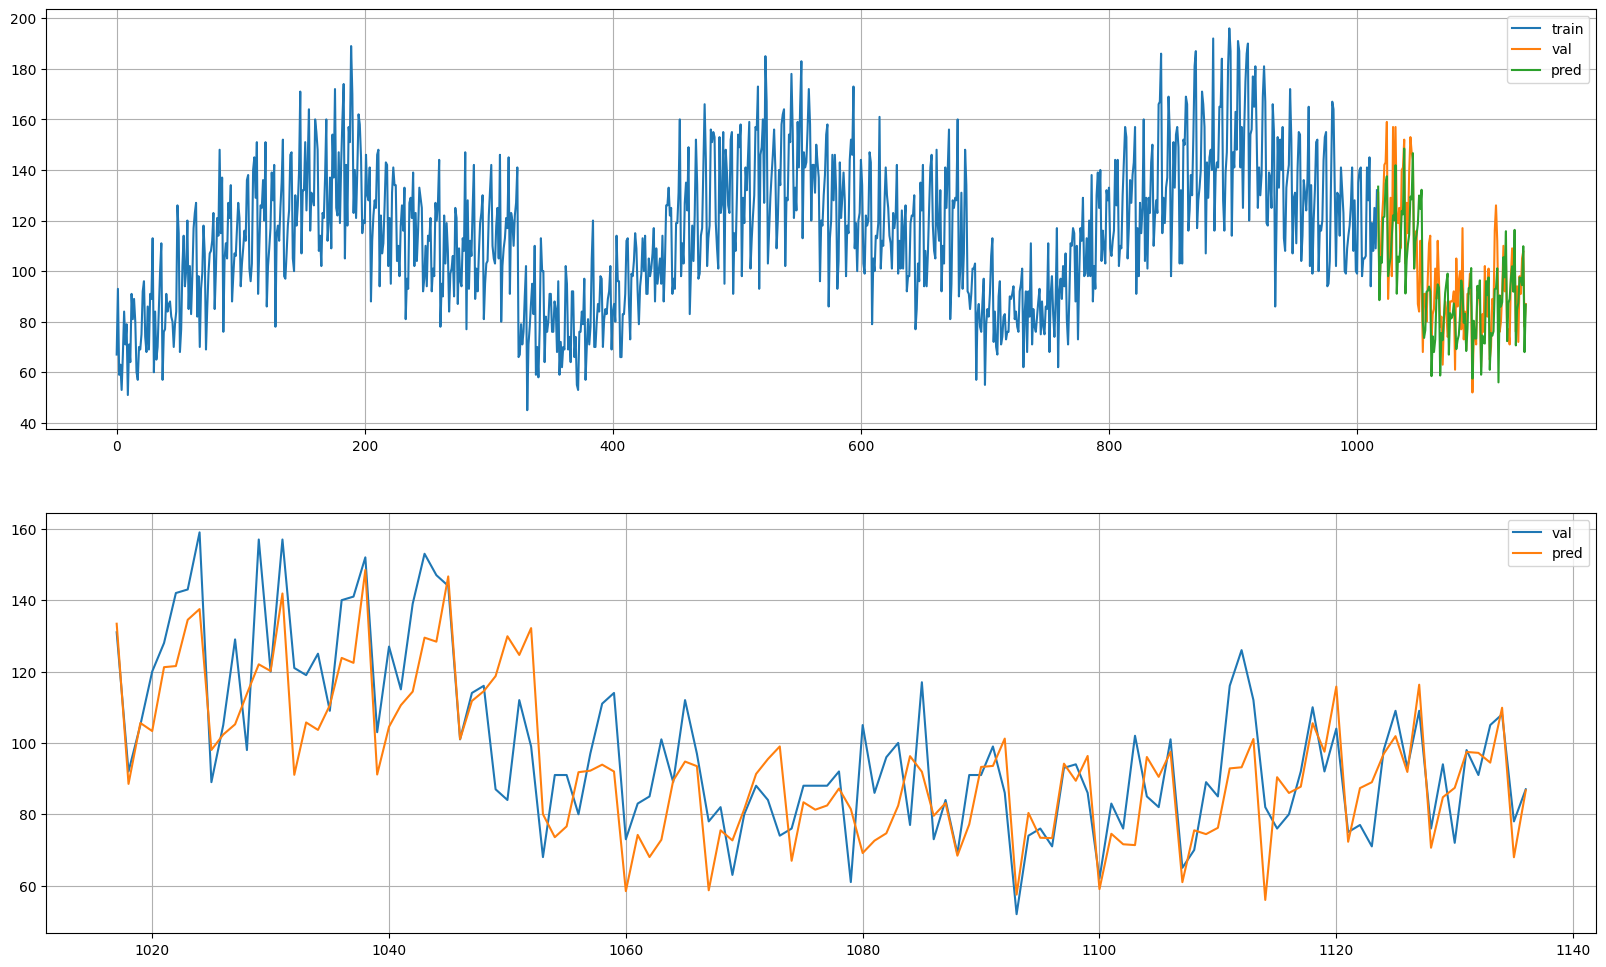

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

# **5.데이터 저장**

* **세부 요구사항**
    * 상품코드별 데이터셋을 저장하시오.
    * joblib.dump를 이용하시오.
    * 저장할 파일의 확장자는 보통 .pkl 입니다.

In [ ]:
import joblib

joblib.dump(data03, path + 'data03.pkl')
joblib.dump(data12, path + 'data12.pkl')
joblib.dump(data42, path + 'data42.pkl')

['/content/drive/MyDrive/project/data42.pkl']